In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
import xgboost as xg
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,Ridge,LinearRegression,LassoCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import time
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import calendar
import tensorflow as tf

In [79]:
#import tensorflow as tf
#tf.__version__

In [2]:
pd.set_option('display.max_columns', None)

## Read Dataset

In [3]:
data=pd.read_csv('cleaned_salesData.csv')

In [4]:
data.head()

,BOROUGH,NEIGHBORHOOD,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE
0,MANHATTAN,CHINATOWN,10013,1920,1190000,2019-07-11
1,MANHATTAN,CHINATOWN,10013,1920,1340000,2019-12-04
2,MANHATTAN,CHINATOWN,10013,1920,2287500,2019-12-09
3,MANHATTAN,CHINATOWN,10013,1920,2070000,2019-05-29
4,MANHATTAN,CHINATOWN,10013,1920,2900000,2019-06-17


In [5]:
data['BOROUGH'].unique()

array(['MANHATTAN'], dtype=object)

In [6]:
del data['BOROUGH']

In [7]:
data['NEIGHBORHOOD'].unique()

array(['CHINATOWN', 'CIVIC CENTER', 'CLINTON', 'EAST VILLAGE', 'FASHION',
       'FINANCIAL', 'FLATIRON', 'GRAMERCY', 'GREENWICH VILLAGE-CENTRAL',
       'GREENWICH VILLAGE-WEST', 'HARLEM-CENTRAL', 'HARLEM-EAST',
       'HARLEM-UPPER', 'HARLEM-WEST', 'INWOOD', 'JAVITS CENTER',
       'KIPS BAY', 'LITTLE ITALY', 'LOWER EAST SIDE', 'MANHATTAN VALLEY',
       'MIDTOWN CBD', 'MIDTOWN EAST', 'MIDTOWN WEST', 'MURRAY HILL',
       'ROOSEVELT ISLAND', 'SOHO', 'SOUTHBRIDGE', 'TRIBECA',
       'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)',
       'UPPER EAST SIDE (96-110)', 'UPPER WEST SIDE (59-79)',
       'UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE (96-116)',
       'WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS UPPER', 'CHELSEA',
       'ALPHABET CITY', 'MORNINGSIDE HEIGHTS'], dtype=object)

In [8]:
data['ZIP CODE'].unique()

array([10013, 10002, 10007, 10036, 10019, 10003, 10009, 10001, 10018,
       10004, 10006, 10005, 10038, 10011, 10010, 10016, 10012, 10014,
       10035, 10030, 10031, 10027, 10026, 10037, 10039, 10029, 10463,
       10034, 10025, 10017, 10022, 10044, 10280, 10282, 10065, 10021,
       10075, 10028, 10128, 10023, 10024, 10069, 10032, 10033, 10040,
           0], dtype=int64)

In [9]:
data['YEAR BUILT'].unique()

array([1920, 1990, 2007, 2003, 1900, 1915, 2012, 2014, 1910, 2018, 1913,
       2008, 1931, 1930, 2009, 2010, 2013, 1924, 2006, 1940, 1988, 2017,
       2005, 1899, 1901, 2015, 1911, 1984, 1927, 1929, 2004, 2016, 1956,
       1982, 1914, 1987, 1928, 1903, 1967, 1840, 1909, 1906, 1986, 1983,
       1961, 1912, 1851, 1952, 1957, 1965, 1905, 1985, 1921, 1907, 1966,
       2002, 1941, 1895, 1938, 1904, 1892, 1951, 1908, 1925, 1962, 2001,
       1922, 1926, 2011, 1960, 1902, 1989, 1937, 1975, 1979, 1958, 1980,
       1977, 1959, 1972, 1981, 1968, 1923, 1950, 1942, 1947, 1978, 1955,
       1917, 1964, 1963, 1880, 1886, 1873, 2000, 1894, 1875, 1969, 1991,
       1916, 1996, 1999, 1939, 1974, 1973, 1998, 1932, 1970, 1971, 1954,
          0, 1918, 1836, 1935, 1919, 1948, 1860, 1841, 1857, 1890, 1879,
       1800, 1953, 1893, 1934, 1883, 1874, 1889, 1821, 1896, 2019],
      dtype=int64)

In [10]:
#Exclude the listings include "0" to keep the accuracy of the model
data= data[data['ZIP CODE'] != 0]
data= data[data['YEAR BUILT'] != 0]

In [11]:
# break date to year and month separatly
data['Year']=data['SALE DATE'].str[:4].astype('int')

In [12]:
data['Month']=data['SALE DATE'].str[5:7].astype('int')

In [13]:
data['Day']=data['SALE DATE'].str[8:].astype('int')

In [14]:
data.head()

,NEIGHBORHOOD,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,Year,Month,Day
0,CHINATOWN,10013,1920,1190000,2019-07-11,2019,7,11
1,CHINATOWN,10013,1920,1340000,2019-12-04,2019,12,4
2,CHINATOWN,10013,1920,2287500,2019-12-09,2019,12,9
3,CHINATOWN,10013,1920,2070000,2019-05-29,2019,5,29
4,CHINATOWN,10013,1920,2900000,2019-06-17,2019,6,17


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


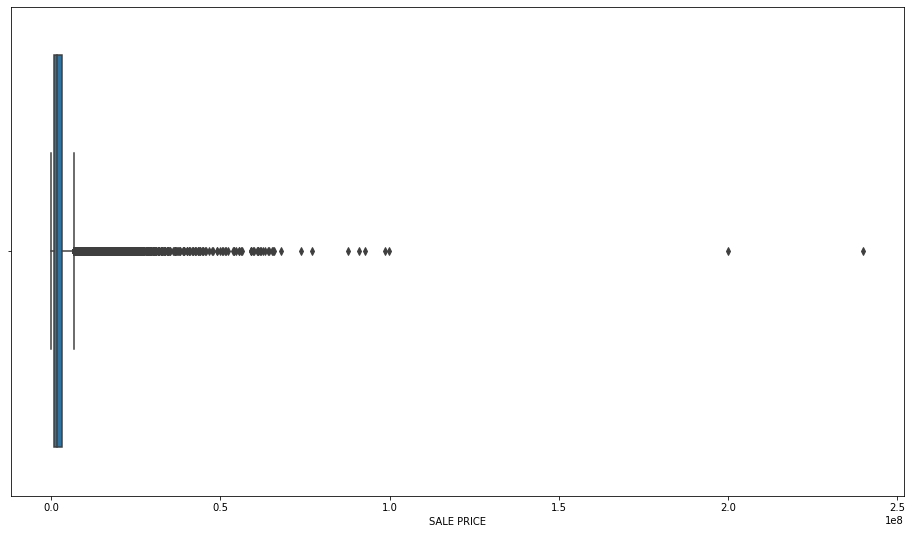

In [93]:
# check outliers for target values with box plot
plt.figure(figsize=(16,9))
sns.boxplot(data['SALE PRICE'])
plt.show()

In [94]:
# take a look at upper percentile of the target values
np.percentile(data['SALE PRICE'],99)

26018323.400000177

In [95]:
# take a look at lower percentile of the target values
np.percentile(data['SALE PRICE'],1)

276843.0

In [96]:
# drop values that are higher than 99th percentile
# drop values that are lower than 1th percentile
data.drop(index=data[data['SALE PRICE']<275000.0].index,inplace=True)
data.drop(index=data[data['SALE PRICE']>24161569.99999995].index,inplace=True)

In [97]:
y=data['SALE PRICE']
x=data.drop(columns=['SALE PRICE'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


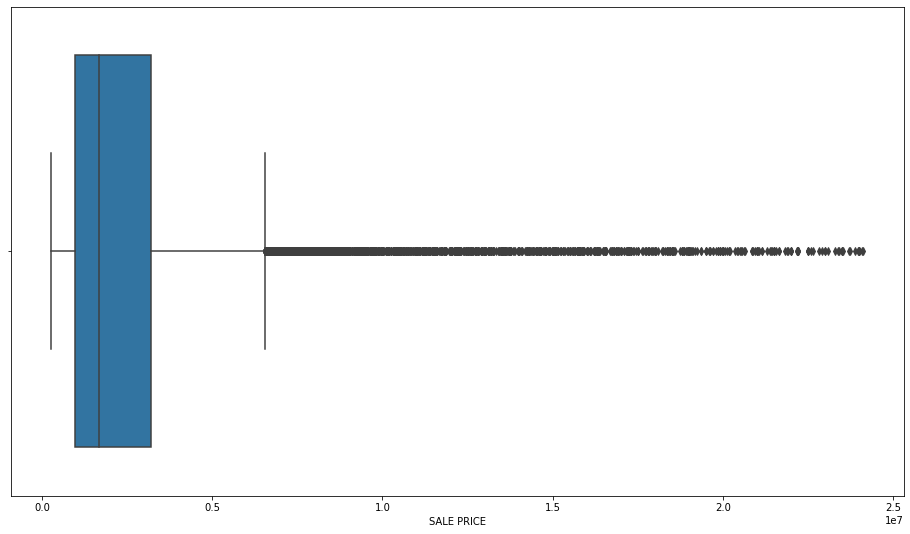

In [98]:
# box plot seems better than before after droping the outliers
plt.figure(figsize=(16,9))
sns.boxplot(y)
plt.show()

<AxesSubplot:>

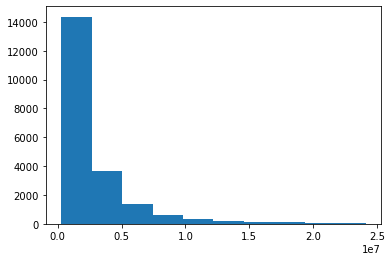

In [99]:
# prices are right skewed, log transformation may be a good choice
y.hist(grid=False)

In [100]:
# extract all numerical columns
num_col=[col for col in x.columns if x[col].dtype!='O']

In [101]:
num_col

['ZIP CODE', 'YEAR BUILT', 'Year', 'Month', 'Day']

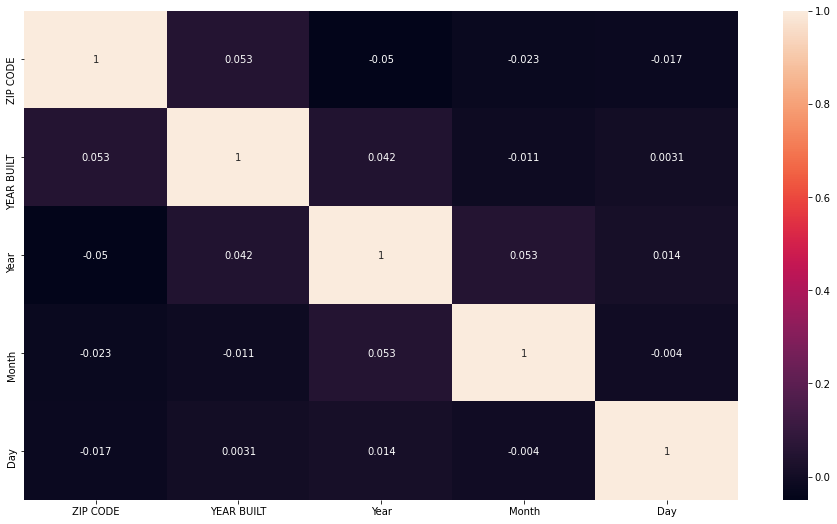

In [102]:
# see correlations between numerical columns
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(data[num_col].corr(),ax=ax,annot=True)
plt.show()

Text(0.5, 0, 'Counts')

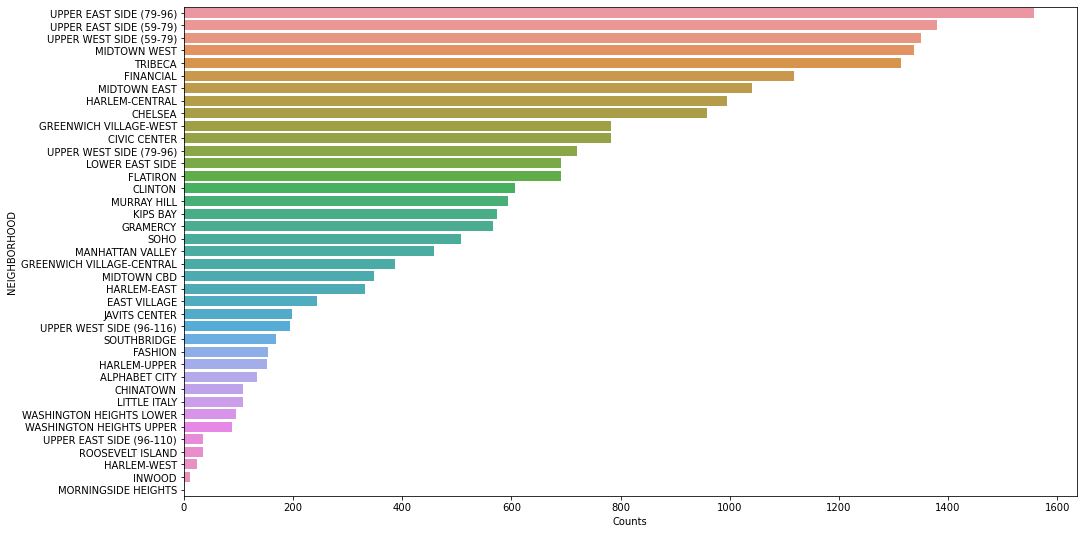

In [103]:
#Plot the number of listings counts based on neighborhood
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(x=data['NEIGHBORHOOD'].value_counts().values,y=data['NEIGHBORHOOD'].value_counts().index,ax=ax)
plt.ylabel('NEIGHBORHOOD')
plt.xlabel('Counts')

Text(0.5, 0, 'mean price')

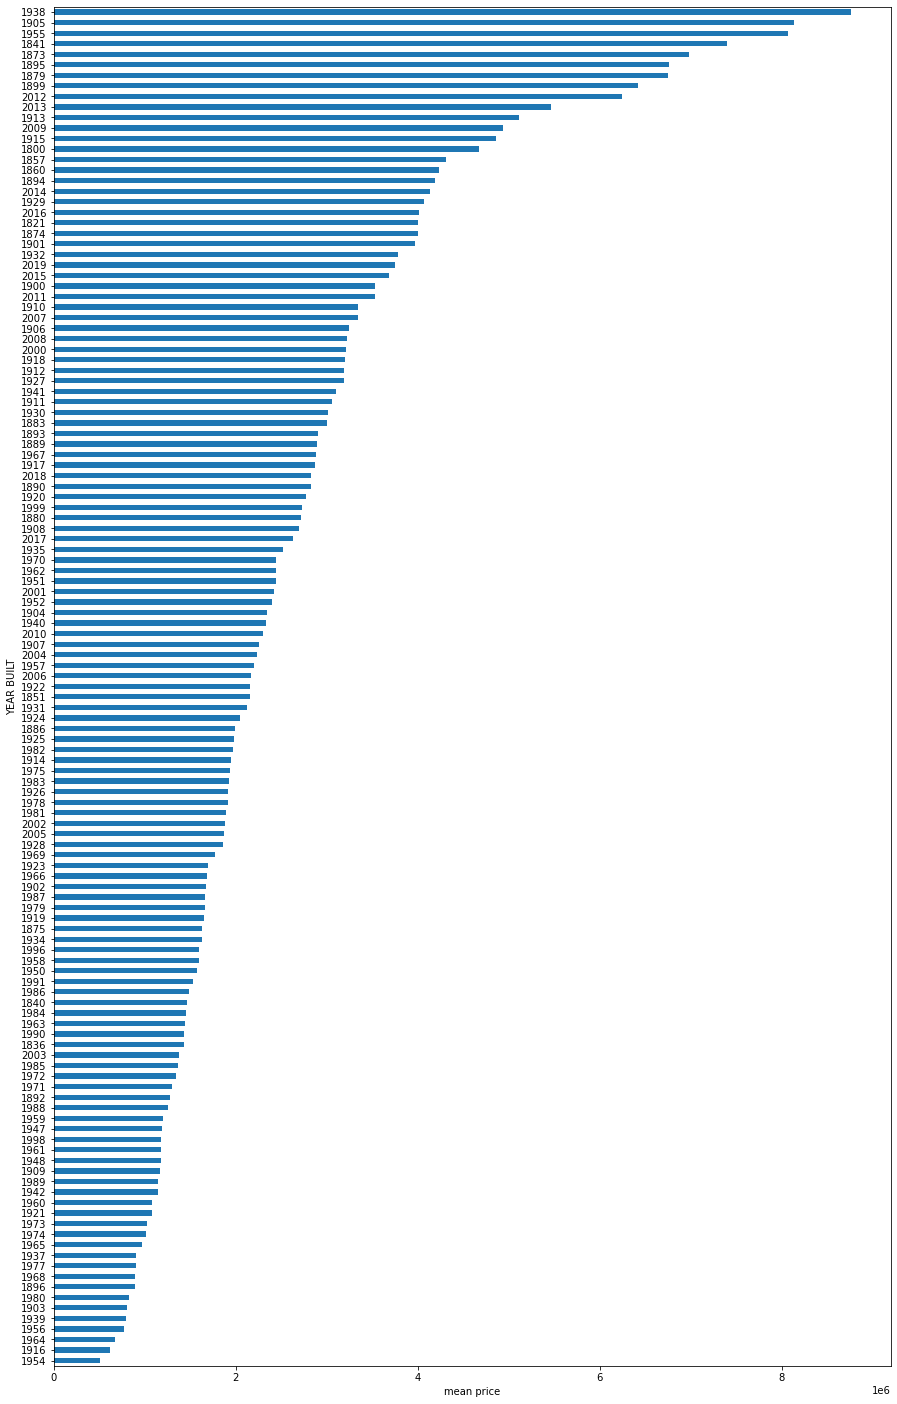

In [104]:
#Plot mean of sales prices based on building year built
data['SALE PRICE']=y
data.groupby('YEAR BUILT')['SALE PRICE'].mean().sort_values().plot(kind='barh',figsize=(15,25),alpha=1.0)
plt.xlabel('mean price')

Text(0.5, 0, 'mean price')

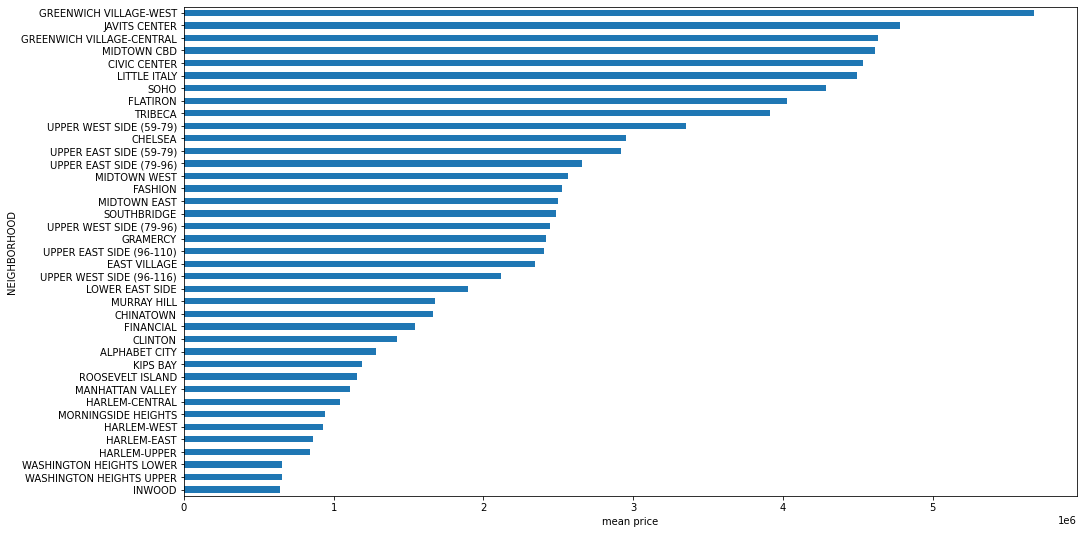

In [105]:
#Plot mean of sales prices based on neighborhood
data['SALE PRICE']=y
data.groupby('NEIGHBORHOOD')['SALE PRICE'].mean().sort_values().plot(kind='barh',figsize=(16,9),alpha=1.0)
plt.xlabel('mean price')

In [106]:
neighborhood=['UPPER EAST SIDE (79-96)','UPPER EAST SIDE (59-79)','UPPER WEST SIDE (59-79)','MIDTOWN WEST','TRIBECA']
neighborhood

['UPPER EAST SIDE (79-96)',
 'UPPER EAST SIDE (59-79)',
 'UPPER WEST SIDE (59-79)',
 'MIDTOWN WEST',
 'TRIBECA']

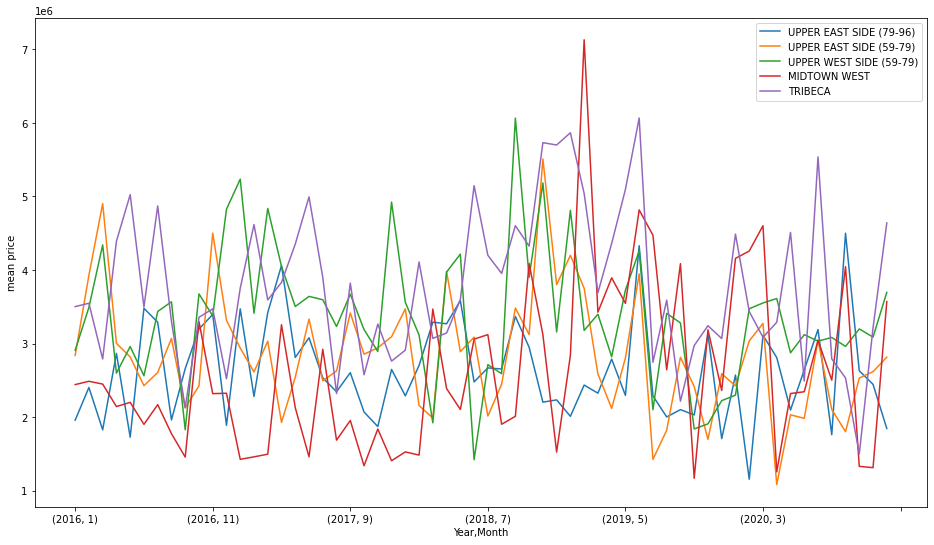

In [107]:
#Plot Top 5 Neighborhood's mean sales price grouped by Year, Month 
data[data['NEIGHBORHOOD']=='UPPER EAST SIDE (79-96)'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
data[data['NEIGHBORHOOD']=='UPPER EAST SIDE (59-79)'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
data[data['NEIGHBORHOOD']=='UPPER WEST SIDE (59-79)'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
data[data['NEIGHBORHOOD']=='MIDTOWN WEST'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
data[data['NEIGHBORHOOD']=='TRIBECA'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
#data[data['NEIGHBORHOOD']=='FINANCIAL'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
#data[data['NEIGHBORHOOD']=='MIDTOWN EAST'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
#data[data['NEIGHBORHOOD']=='HARLEM-CENTRAL'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
#data[data['NEIGHBORHOOD']=='CHELSEA'].groupby(['Year','Month'])['SALE PRICE'].mean().plot(figsize=(16,9))
plt.ylabel('mean price')
plt.legend(neighborhood)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


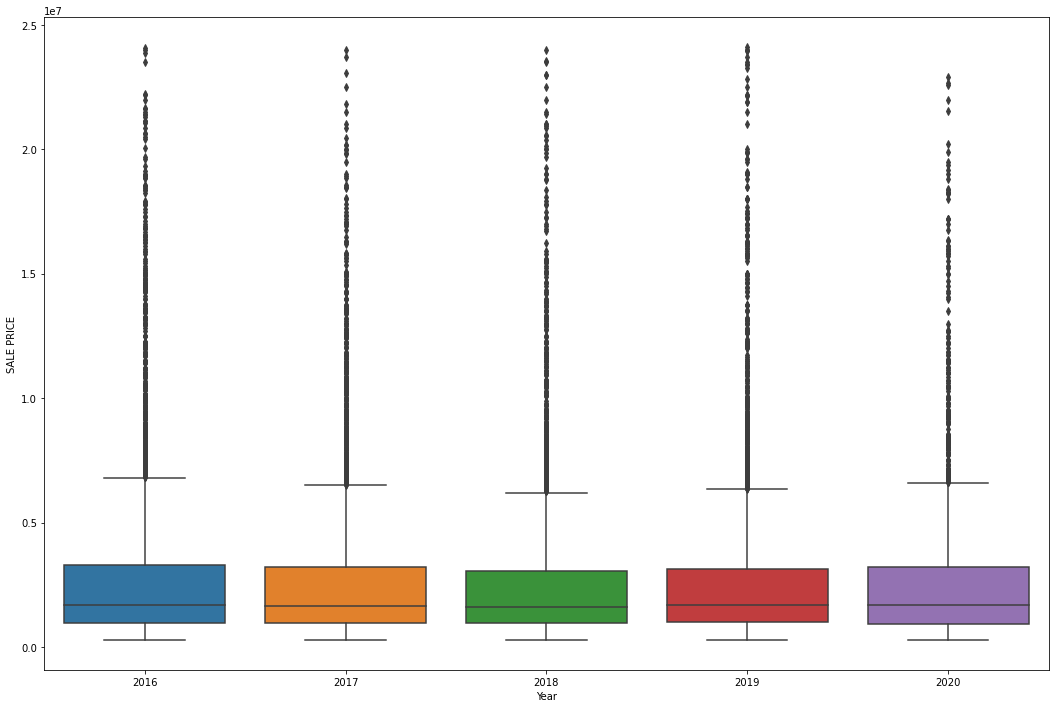

In [108]:
# the median price over time does not change significantly
plt.figure(figsize=(18,12))
sns.boxplot(data['Year'],data['SALE PRICE'])
plt.show()

## Modeling

In [109]:
#split 30% as validation dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [110]:
# as we mentioned ahead, prices are right skewed, transmation may be good choice especially for linear model which requires
# response variable need to be normally distributed
log_y_train=np.log(y_train)
log_y_test=np.log(y_test)

In [111]:
#let's exclucde catogorial column and sale date column first to see model performance
x_train.drop(columns = ['NEIGHBORHOOD', 'SALE DATE'], inplace = True)
x_test.drop(columns = ['NEIGHBORHOOD', 'SALE DATE'], inplace = True)
y_train.drop(columns = ['NEIGHBORHOOD', 'SALE DATE'], inplace = True)
y_test.drop(columns = ['NEIGHBORHOOD', 'SALE DATE'], inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [112]:
x_train.head()

,ZIP CODE,YEAR BUILT,Year,Month,Day
4868,10019,1987,2016,1,11
12281,10011,2008,2017,4,10
7744,10011,1930,2016,6,16
24205,10023,1983,2020,2,27
6938,10002,2010,2016,5,4


In [113]:
xgb_r = xg.XGBRegressor(max_depth=10,
                           n_estimators=300,
                           min_child_weight=9,
                           learning_rate=0.05,
                           nthread=8,
                           subsample=0.80,
                           colsample_bytree=0.8,
                           seed=4242
                           )

In [114]:
start=time.time()
xgb_r.fit(x_train,log_y_train,
          eval_metric='rmse',
            eval_set=[(x_test,log_y_test)])
end=time.time()
print('time: ',end-start,'seconds')

[0]	validation_0-rmse:13.26629
[1]	validation_0-rmse:12.60548
[2]	validation_0-rmse:11.97828
[3]	validation_0-rmse:11.38198
[4]	validation_0-rmse:10.81593
[5]	validation_0-rmse:10.27833
[6]	validation_0-rmse:9.76753
[7]	validation_0-rmse:9.28256
[8]	validation_0-rmse:8.82177
[9]	validation_0-rmse:8.38495
[10]	validation_0-rmse:7.97004
[11]	validation_0-rmse:7.57561
[12]	validation_0-rmse:7.20121
[13]	validation_0-rmse:6.84531
[14]	validation_0-rmse:6.50803
[15]	validation_0-rmse:6.18709
[16]	validation_0-rmse:5.88250
[17]	validation_0-rmse:5.59315
[18]	validation_0-rmse:5.31854
[19]	validation_0-rmse:5.05821
[20]	validation_0-rmse:4.81099
[21]	validation_0-rmse:4.57565
[22]	validation_0-rmse:4.35240
[23]	validation_0-rmse:4.14139
[24]	validation_0-rmse:3.94017
[25]	validation_0-rmse:3.74931
[26]	validation_0-rmse:3.56838
[27]	validation_0-rmse:3.39682
[28]	validation_0-rmse:3.23364
[29]	validation_0-rmse:3.07953
[30]	validation_0-rmse:2.93275
[31]	validation_0-rmse:2.79371
[32]	validat

[260]	validation_0-rmse:0.56254
[261]	validation_0-rmse:0.56259
[262]	validation_0-rmse:0.56271
[263]	validation_0-rmse:0.56270
[264]	validation_0-rmse:0.56295
[265]	validation_0-rmse:0.56291
[266]	validation_0-rmse:0.56289
[267]	validation_0-rmse:0.56304
[268]	validation_0-rmse:0.56308
[269]	validation_0-rmse:0.56322
[270]	validation_0-rmse:0.56321
[271]	validation_0-rmse:0.56323
[272]	validation_0-rmse:0.56333
[273]	validation_0-rmse:0.56325
[274]	validation_0-rmse:0.56328
[275]	validation_0-rmse:0.56343
[276]	validation_0-rmse:0.56351
[277]	validation_0-rmse:0.56354
[278]	validation_0-rmse:0.56353
[279]	validation_0-rmse:0.56346
[280]	validation_0-rmse:0.56357
[281]	validation_0-rmse:0.56353
[282]	validation_0-rmse:0.56371
[283]	validation_0-rmse:0.56386
[284]	validation_0-rmse:0.56380
[285]	validation_0-rmse:0.56388
[286]	validation_0-rmse:0.56387
[287]	validation_0-rmse:0.56394
[288]	validation_0-rmse:0.56378
[289]	validation_0-rmse:0.56382
[290]	validation_0-rmse:0.56398
[291]	va

In [115]:
# mse of training set
mean_squared_error(log_y_train,xgb_r.predict(x_train))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.1473352321754756

In [116]:
# mse of validation set
mean_squared_error(log_y_test,xgb_r.predict(x_test))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.3188064815438333

In [117]:
# Now, let's keep categorical data to run the model and see how the performance differs
# encoding the categorical data

y1=data['SALE PRICE']
x1=data.drop(columns=['SALE PRICE'])

x1_train,x1_test,y1_train,y1_test=train_test_split(x1,y1,test_size=0.3,random_state=0)

log_y1_train=np.log(y1_train)
log_y1_test=np.log(y1_test)

x1_train['Month']=x1_train['Month'].map(lambda x: calendar.month_name[int(x)])
x1_test['Month']=x1_test['Month'].map(lambda x: calendar.month_name[int(x)])
x1_train1=pd.get_dummies(x1_train.drop(columns=['SALE DATE']),drop_first=True)
x1_test1=pd.get_dummies(x1_test.drop(columns=['SALE DATE']),drop_first=True)

<ipython-input-117-95b64b45ed79>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1_train['Month']=x1_train['Month'].map(lambda x: calendar.month_name[int(x)])
<ipython-input-117-95b64b45ed79>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1_test['Month']=x1_test['Month'].map(lambda x: calendar.month_name[int(x)])


In [118]:
x1_train1['SALE DATE']=x1_train['SALE DATE']
x1_test1['SALE DATE']=x1_test['SALE DATE']
x1_train1

,ZIP CODE,YEAR BUILT,Year,Day,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_CHINATOWN,NEIGHBORHOOD_CIVIC CENTER,NEIGHBORHOOD_CLINTON,NEIGHBORHOOD_EAST VILLAGE,NEIGHBORHOOD_FASHION,NEIGHBORHOOD_FINANCIAL,NEIGHBORHOOD_FLATIRON,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL,NEIGHBORHOOD_GREENWICH VILLAGE-WEST,NEIGHBORHOOD_HARLEM-CENTRAL,NEIGHBORHOOD_HARLEM-EAST,NEIGHBORHOOD_HARLEM-UPPER,NEIGHBORHOOD_HARLEM-WEST,NEIGHBORHOOD_INWOOD,NEIGHBORHOOD_JAVITS CENTER,NEIGHBORHOOD_KIPS BAY,NEIGHBORHOOD_LITTLE ITALY,NEIGHBORHOOD_LOWER EAST SIDE,NEIGHBORHOOD_MANHATTAN VALLEY,NEIGHBORHOOD_MIDTOWN CBD,NEIGHBORHOOD_MIDTOWN EAST,NEIGHBORHOOD_MIDTOWN WEST,NEIGHBORHOOD_MURRAY HILL,NEIGHBORHOOD_ROOSEVELT ISLAND,NEIGHBORHOOD_SOHO,NEIGHBORHOOD_SOUTHBRIDGE,NEIGHBORHOOD_TRIBECA,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER EAST SIDE (96-110),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (96-116),NEIGHBORHOOD_WASHINGTON HEIGHTS LOWER,NEIGHBORHOOD_WASHINGTON HEIGHTS UPPER,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,SALE DATE
4868,10019,1987,2016,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2016-01-11
12281,10011,2008,2017,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-04-10
7744,10011,1930,2016,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2016-06-16
24205,10023,1983,2020,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2020-02-27
6938,10002,2010,2016,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2016-05-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15557,10036,2005,2017,31,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2017-10-31
23419,10012,2004,2020,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2020-12-04
11419,10013,1915,2017,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2017-02-14
12597,10005,1987,2017,28,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-04-28


In [119]:
xgb_r = xg.XGBRegressor(max_depth=10,
                           n_estimators=300,
                           min_child_weight=9,
                           learning_rate=0.05,
                           nthread=8,
                           subsample=0.80,
                           colsample_bytree=0.8,
                           seed=4242
                           )

In [120]:
x1_train1.drop(columns=['SALE DATE'],inplace=True)
x1_test1.drop(columns=['SALE DATE'],inplace=True)

In [121]:
x['NEIGHBORHOOD'].value_counts()

UPPER EAST SIDE (79-96)      1558
UPPER EAST SIDE (59-79)      1380
UPPER WEST SIDE (59-79)      1350
MIDTOWN WEST                 1337
TRIBECA                      1314
FINANCIAL                    1118
MIDTOWN EAST                 1041
HARLEM-CENTRAL                995
CHELSEA                       958
GREENWICH VILLAGE-WEST        782
CIVIC CENTER                  782
UPPER WEST SIDE (79-96)       721
LOWER EAST SIDE               691
FLATIRON                      690
CLINTON                       607
MURRAY HILL                   593
KIPS BAY                      574
GRAMERCY                      567
SOHO                          507
MANHATTAN VALLEY              458
GREENWICH VILLAGE-CENTRAL     387
MIDTOWN CBD                   348
HARLEM-EAST                   331
EAST VILLAGE                  244
JAVITS CENTER                 198
UPPER WEST SIDE (96-116)      194
SOUTHBRIDGE                   168
FASHION                       154
HARLEM-UPPER                  153
ALPHABET CITY 

In [122]:
# It keeps showing error saying the training set is missing "NEIGHBORHOOD_MORNINGSIDE HEIGHTS"
# we choose to exclude this column since the morningside heights value has only one
x1_test1.drop(columns=['NEIGHBORHOOD_MORNINGSIDE HEIGHTS'],inplace=True)

In [123]:
start=time.time()
xgb_r.fit(x1_train1,log_y1_train,
          eval_metric='rmse',
            eval_set=[(x1_test1,log_y1_test)])
end=time.time()
print('time: ',end-start,'seconds')

[0]	validation_0-rmse:13.26625
[1]	validation_0-rmse:12.60554
[2]	validation_0-rmse:11.97854
[3]	validation_0-rmse:11.38223
[4]	validation_0-rmse:10.81583
[5]	validation_0-rmse:10.27824
[6]	validation_0-rmse:9.76745
[7]	validation_0-rmse:9.28251
[8]	validation_0-rmse:8.82155
[9]	validation_0-rmse:8.38460
[10]	validation_0-rmse:7.96918
[11]	validation_0-rmse:7.57433
[12]	validation_0-rmse:7.19954
[13]	validation_0-rmse:6.84347
[14]	validation_0-rmse:6.50560
[15]	validation_0-rmse:6.18456
[16]	validation_0-rmse:5.87979
[17]	validation_0-rmse:5.59048
[18]	validation_0-rmse:5.31552
[19]	validation_0-rmse:5.05485
[20]	validation_0-rmse:4.80738
[21]	validation_0-rmse:4.57222
[22]	validation_0-rmse:4.34881
[23]	validation_0-rmse:4.13736
[24]	validation_0-rmse:3.93616
[25]	validation_0-rmse:3.74530
[26]	validation_0-rmse:3.56442
[27]	validation_0-rmse:3.39268
[28]	validation_0-rmse:3.22954
[29]	validation_0-rmse:3.07509
[30]	validation_0-rmse:2.92869
[31]	validation_0-rmse:2.78981
[32]	validat

[260]	validation_0-rmse:0.54496
[261]	validation_0-rmse:0.54495
[262]	validation_0-rmse:0.54495
[263]	validation_0-rmse:0.54499
[264]	validation_0-rmse:0.54509
[265]	validation_0-rmse:0.54506
[266]	validation_0-rmse:0.54502
[267]	validation_0-rmse:0.54501
[268]	validation_0-rmse:0.54497
[269]	validation_0-rmse:0.54497
[270]	validation_0-rmse:0.54488
[271]	validation_0-rmse:0.54483
[272]	validation_0-rmse:0.54474
[273]	validation_0-rmse:0.54491
[274]	validation_0-rmse:0.54485
[275]	validation_0-rmse:0.54495
[276]	validation_0-rmse:0.54497
[277]	validation_0-rmse:0.54493
[278]	validation_0-rmse:0.54501
[279]	validation_0-rmse:0.54499
[280]	validation_0-rmse:0.54493
[281]	validation_0-rmse:0.54468
[282]	validation_0-rmse:0.54462
[283]	validation_0-rmse:0.54456
[284]	validation_0-rmse:0.54453
[285]	validation_0-rmse:0.54461
[286]	validation_0-rmse:0.54457
[287]	validation_0-rmse:0.54462
[288]	validation_0-rmse:0.54466
[289]	validation_0-rmse:0.54476
[290]	validation_0-rmse:0.54477
[291]	va

In [124]:
# mse of training set
mse_xgb_train =mean_squared_error(log_y1_train,xgb_r.predict(x1_train1))
mse_xgb_train

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.17645545115474526

In [125]:
# mse of validation set
mse_xgb_val= mean_squared_error(log_y1_test,xgb_r.predict(x1_test1))
mse_xgb_val

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.29675670390516945

In [ ]:
print("Conclusion: it is better to keep the catrgorical columns. After we add encoding to catrgorical data, the mse for validation set becomes smaller and getting colser to the mse of training set even though the mse of training set gets slightly higher.")

# Building Random Forest Model¶

In [127]:
# this packege will do standardization for the fitted data
sc=StandardScaler()

In [128]:
# try to standardize data
sd_x_train=sc.fit_transform(x1_train1)
sd_x_test=sc.transform(x1_test1)

In [52]:
parameters={"max_depth":range(2, 8), "min_samples_leaf": range(5, 55, 5), "min_samples_split": range(2, 110, 5),
              "max_samples":[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], "max_features": [2, 3, 4, 5, 6],
              "n_estimators": [100, 150, 200, 250, 300]}

In [53]:
s=time.time()
rf=RandomForestRegressor()
clf= RandomizedSearchCV(rf, parameters, n_jobs=4, scoring = "neg_mean_squared_error",n_iter=100)

In [54]:
clf.fit(sd_x_train,log_y1_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=4,
                   param_distributions={'max_depth': range(2, 8),
                                        'max_features': [2, 3, 4, 5, 6],
                                        'max_samples': [0.1, 0.15, 0.2, 0.25,
                                                        0.3, 0.35, 0.4],
                                        'min_samples_leaf': range(5, 55, 5),
                                        'min_samples_split': range(2, 110, 5),
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   scoring='neg_mean_squared_error')

In [55]:
clf.best_params_

{'n_estimators': 300,
 'min_samples_split': 42,
 'min_samples_leaf': 5,
 'max_samples': 0.15,
 'max_features': 6,
 'max_depth': 7}

In [56]:
mse_rf_train=mean_squared_error(log_y1_train,clf.predict(sd_x_train))
mse_rf_train

0.5029719020625827

In [57]:
mse_rf_val=mean_squared_error(log_y1_test,clf.predict(sd_x_test))
mse_rf_val

0.5090668754682898

# Lasso Regression

In [58]:
clf1 = LassoCV(alphas = [1, 0.1, 0.001, 0.0005,0.0003,0.0002, 5e-4],cv=5)
clf1.fit(sd_x_train, log_y1_train)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005, 0.0003, 0.0002, 0.0005], cv=5)

In [59]:
mse_ls_train=mean_squared_error(log_y1_train,clf1.predict(sd_x_train))
mse_ls_train

0.5098069693840599

In [60]:
mse_ls_val=mean_squared_error(log_y1_test,clf1.predict(sd_x_test))
mse_ls_val

0.5101986685292604

# Support vector regressor

In [61]:
svm = LinearSVR()
svm.fit(sd_x_train,log_y1_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR()

In [62]:
mse_svm_train=mean_squared_error(log_y1_train,svm.predict(sd_x_train))
mse_svm_train

0.5194027718357302

In [63]:
mse_svm_val=mean_squared_error(log_y_test,svm.predict(sd_x_test))
mse_svm_val

0.5178212449725227

# Building Neural_Networks using tensorflow

In [64]:
def mymodel():
    inputdim = sd_x_train.shape[1]
    #print(inputdim)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(inputdim,)))    #input array of shape (None, inputdim)
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(258, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    
    
    #useoptimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    #model.compile(loss = 'mean_squared_error', optimizer=useoptimizer)
    
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [65]:
s=time.time()
res = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn = mymodel, epochs=120, verbose=0)
res.fit(sd_x_train,log_y1_train)
e=time.time()
print(e-s)

142.55716919898987


In [66]:
mse_nn_train=mean_squared_error(log_y1_train,res.predict(sd_x_train))
mse_nn_train

0.21121093517529327

In [67]:
mse_nn_val=mean_squared_error(log_y1_test,res.predict(sd_x_test))
mse_nn_val

0.48330945630676325

In [68]:
mse_df=pd.DataFrame({'train':[mse_xgb_train,mse_rf_train,mse_ls_train,mse_svm_train,mse_nn_train],'val':\
 [mse_xgb_val,mse_rf_val,mse_ls_val,mse_svm_val,mse_nn_val]},index=['Xgboost','Random_Forest','Lasso','SVR','Neural_Networks'])

mse_df

,train,val
Xgboost,0.176455,0.296757
Random_Forest,0.502972,0.509067
Lasso,0.509807,0.510199
SVR,0.519403,0.517821
Neural_Networks,0.211211,0.483309


In [69]:
#Conclusion: xgboost has overfitting problem but best performance. 
#            Random forest, Lasso and SVR have least overfitting problem. 
#            Neural Networks has largest overfitting problem. 

Text(0.5, 1.0, 'Model Performance')

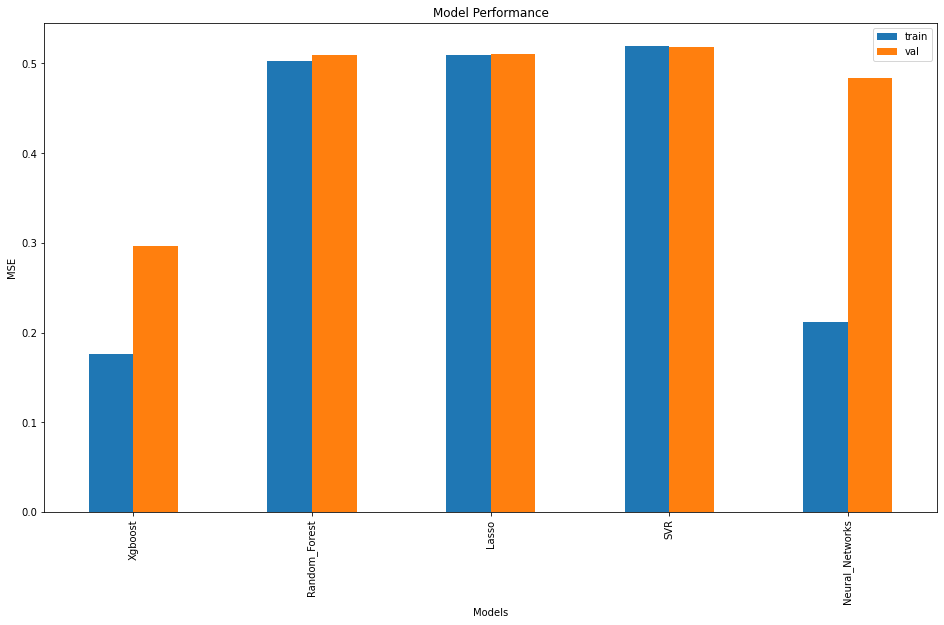

In [70]:
mse_df.plot(kind='bar',figsize=(16,9))
plt.ylabel('MSE')
plt.xlabel('Models')
plt.title('Model Performance')

# Building Optimal XGboost regressor

In [71]:
parameters = {"max_depth":range(3, 12), "min_samples_leaf": range(5, 55, 5), "min_samples_split": range(10, 110, 5),
              "max_samples":[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], "max_features": [2, 3, 4, 5, 6],
              "n_estimators": [100, 150, 200,300,400],
             'learning_rate':[0.01,0.03,0.05,0.08,0.1,0.15,0.3],
             'nthread':range(2,10,2)}

In [72]:
xgb_r2 = xg.XGBRegressor(
                           n_estimators=300,
                           min_child_weight=9,
                           nthread=8,
                           subsample=0.80,
                           colsample_bytree=0.8,
                           seed=4242
                           )

In [73]:
xgr = RandomizedSearchCV(xgb_r2, parameters, n_jobs=4,scoring='neg_root_mean_squared_error',n_iter=200)

In [74]:
s=time.time()
xgr.fit(sd_x_train,log_y_train,
            eval_metric='rmse',
            eval_set=[(sd_x_test,log_y_test)])
e=time.time()
print(e-s)

[23:41:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "max_features", "max_samples", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:13.54436
[1]	validation_0-rmse:13.13955
[2]	validation_0-rmse:12.74709
[3]	validation_0-rmse:12.36623
[4]	validation_0-rmse:11.99680
[5]	validation_0-rmse:11.63869
[6]	validation_0-rmse:11.29130
[7]	validation_0-rmse:10.95456
[8]	validation_0-rmse:10.62768
[9]	validation_0-rmse:10.31107
[10]	validation_0-rmse:10.00378
[11]	validation_0-rmse:9.70557
[12]	validation_0-rmse:9.41629
[13]	validation_0-rmse:9.13574
[14]	validation_0-rmse:8.86370
[15]	validation_0-rmse:8.59994
[16]	validation_0-rmse:8.34423
[17]	validation_0-rmse:8.09616
[18]	validation_0-rms

[246]	validation_0-rmse:0.54766
[247]	validation_0-rmse:0.54759
[248]	validation_0-rmse:0.54762
[249]	validation_0-rmse:0.54749
[250]	validation_0-rmse:0.54745
[251]	validation_0-rmse:0.54743
[252]	validation_0-rmse:0.54732
[253]	validation_0-rmse:0.54729
[254]	validation_0-rmse:0.54717
[255]	validation_0-rmse:0.54715
[256]	validation_0-rmse:0.54713
[257]	validation_0-rmse:0.54709
[258]	validation_0-rmse:0.54702
[259]	validation_0-rmse:0.54700
[260]	validation_0-rmse:0.54697
[261]	validation_0-rmse:0.54688
[262]	validation_0-rmse:0.54684
[263]	validation_0-rmse:0.54682
[264]	validation_0-rmse:0.54689
[265]	validation_0-rmse:0.54670
[266]	validation_0-rmse:0.54661
[267]	validation_0-rmse:0.54662
[268]	validation_0-rmse:0.54662
[269]	validation_0-rmse:0.54653
[270]	validation_0-rmse:0.54641
[271]	validation_0-rmse:0.54640
[272]	validation_0-rmse:0.54634
[273]	validation_0-rmse:0.54641
[274]	validation_0-rmse:0.54618
[275]	validation_0-rmse:0.54616
[276]	validation_0-rmse:0.54616
[277]	va

In [75]:
#optimal parameters
xgr.best_params_

{'nthread': 2,
 'n_estimators': 400,
 'min_samples_split': 50,
 'min_samples_leaf': 10,
 'max_samples': 0.3,
 'max_features': 5,
 'max_depth': 11,
 'learning_rate': 0.03}

<AxesSubplot:ylabel='var'>

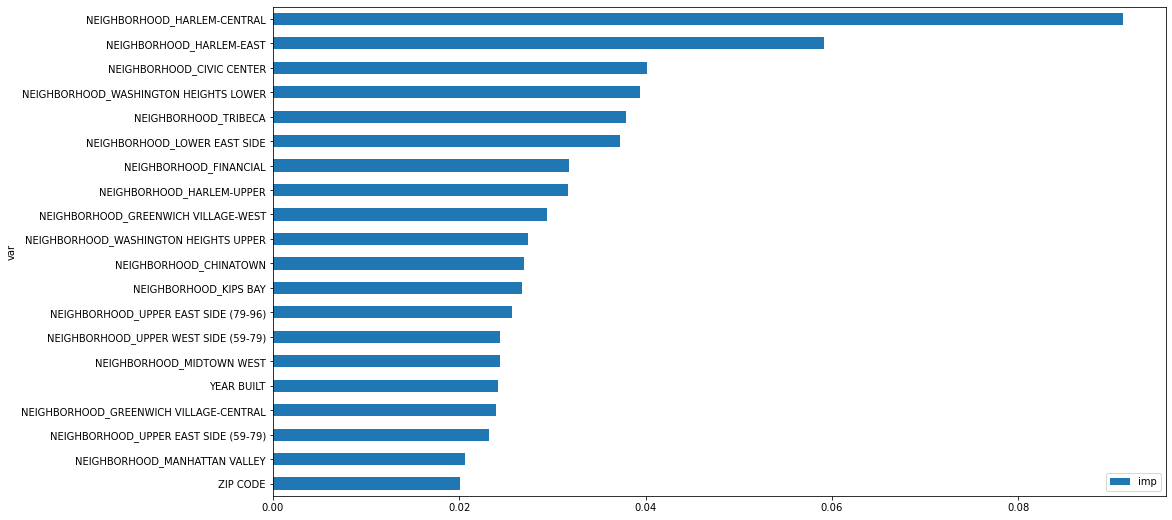

In [76]:
imp = pd.DataFrame()
imp["var"] = x1_train1.columns
imp["imp"] = xgr.best_estimator_.feature_importances_
imp = imp.sort_values("imp", ascending = False).reset_index(drop = True)
imp.head(20).sort_values('imp').plot(kind='barh',x='var',figsize=(16,9))

In [130]:
mse_xgb_train=mean_squared_error(log_y_train,xgr.predict(sd_x_train))
mse_xgb_train

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.17770709274838933

In [131]:
mse_xgb_val=mean_squared_error(log_y_test,xgr.predict(sd_x_test))
mse_xgb_val

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.2957097954350422

## Add Price Caculator

In [1]:
from datetime import timedelta
from datetime import date
from datetime import datetime
from datascience import *
from scipy.spatial import distance
from IPython.display import display
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import IntSlider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Constansts

output_directory = "output/"

COL_PURCHASE_DATE = 'PURCHASE DATE'
COL_SOLD_DATE = 'SOLD DATE'
COL_PURCHASE_PRICE = 'PURCHASE PRICE'
COL_SOLD_PRICE = 'SOLD PRICE'

COL_PRICE_PERCENT = 'PRICE CHANGE %'

# Columns for standard units
COL_PURCHASE_DATE_SU = 'PURCHASE DATE SU'
COL_PURCHASE_PRICE_SU = 'PURCHASE PRICE SU'
COL_SOLD_DATE_SU = 'SOLD DATE SU'

In [15]:
data.head()

,NEIGHBORHOOD,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,Year,Month,Day
0,CHINATOWN,10013,1920,1190000,2019-07-11,2019,7,11
1,CHINATOWN,10013,1920,1340000,2019-12-04,2019,12,4
2,CHINATOWN,10013,1920,2287500,2019-12-09,2019,12,9
3,CHINATOWN,10013,1920,2070000,2019-05-29,2019,5,29
4,CHINATOWN,10013,1920,2900000,2019-06-17,2019,6,17


In [16]:
# DATE is  but should be datetime
#data['SALE PRICE']= pd.to_datetime(data['COL_SOLD_DATE'], errors='coerce')
#we can't continue here as the dataset missing purchase price and purchase dates 
#the price predictor needs purchase and sales details to calculate the distances